**Insurance Company Data Analysis and Modeling**

**Objective:** The objective of this exercise is to clean, preprocess, and model real-life insurance data. I have been provided with two datasets: one for training (train.csv) and one for testing (test.csv). The goal is to predict class probabilities for belonging to the positive class (labeled '1').

In [ ]:
!pip install fancyimpute

In [5]:
#import libraries
import pandas as pd
import numpy as np
import calendar
from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [6]:
df_train = pd.read_csv('exercise_40_train.csv')
df_test = pd.read_csv('exercise_40_test.csv')

#Step 1 - EDA

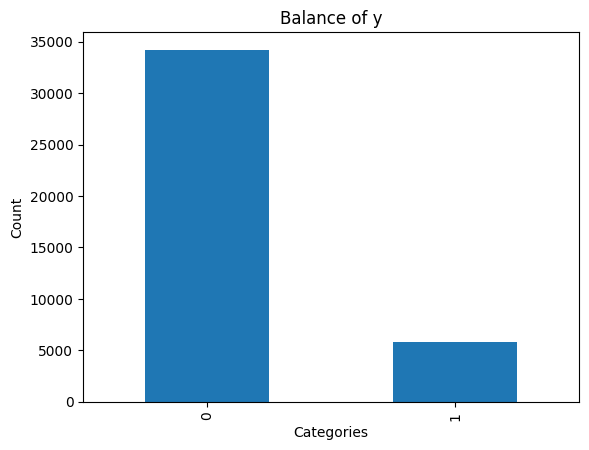

In [7]:
# Assessing the Balance of Training Data
# Visualizing the distribution of target variable 'y' to check for balance

# Count the occurrences of each value in the 'y' column
target_counts = df_train['y'].value_counts()

# Create the bar plot
target_counts.plot(kind='bar');

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Balance of y')

plt.show()

In [8]:
# Extracting Categorical Columns and Their Unique Values
# Selecting all columns in the training dataframe with an object data type (i.e., categorical columns)
categorical_df = df_train.loc[:,df_train.dtypes == object]

# Iterate over each categorical column and store its unique values in the dictionary
cat_dict = {}
for col in categorical_df.columns:
  cat_dict[col] = categorical_df[col].unique()

print(cat_dict)

{'x3': array(['Wed', 'Friday', 'Thursday', 'Tuesday', 'Sunday', 'Saturday',
       'Sat', 'Wednesday', 'Sun', 'Tue', 'Thur', 'Monday', 'Fri', 'Mon'],
      dtype=object), 'x7': array(['0.0062%', '0.0064%', '-8e-04%', '-0.0057%', '0.0109%', '0.0079%',
       '0.0174%', '-0.0106%', '0.0032%', '0.0091%', '-0.0052%',
       '-0.0025%', '-0.0045%', '0.0068%', '-0.0137%', '-0.0014%',
       '-0.0013%', '0.0066%', '0.0097%', '-0.0086%', '0.0023%',
       '-0.0023%', '-0.0107%', '-0.0134%', '0.0058%', '-2e-04%',
       '-0.0033%', '-0.0172%', '-0.0026%', '-0.0118%', '0.0105%',
       '-0.0055%', '0.0095%', '0.0026%', '-0.0051%', '0.0054%',
       '-0.0167%', '0.0015%', '-0.0037%', '0.0011%', '-0.0097%',
       '-0.0016%', '-0.0155%', '0.015%', '-0.0032%', '2e-04%', '0.0122%',
       '0.0082%', '-0.0054%', '-0.0017%', '0.0013%', '0.0025%',
       '-0.0021%', '-0.017%', '-0.005%', '0.0014%', '-0.0103%', '-0.018%',
       '-0.0077%', '-0.0115%', '-0.0018%', '6e-04%', '-0.0169%',
       '0.0051%',

In [9]:
# Counting Null Values in the Training DataFrame
for col in df_train.columns:
  null_count = df_train[col].isnull().sum()
  print(col,null_count)

y 0
x1 0
x2 0
x3 0
x4 0
x5 2428
x6 0
x7 0
x8 0
x9 0
x10 0
x11 5110
x12 0
x13 0
x14 9864
x15 0
x16 11212
x17 0
x18 0
x19 0
x20 0
x21 0
x22 2387
x23 0
x24 3856
x25 0
x26 2433
x27 0
x28 0
x29 0
x30 32336
x31 0
x32 0
x33 7171
x34 0
x35 0
x36 0
x37 0
x38 2402
x39 0
x40 0
x41 9503
x42 9729
x43 0
x44 34247
x45 8009
x46 0
x47 0
x48 0
x49 12823
x50 0
x51 0
x52 16182
x53 0
x54 12728
x55 17696
x56 0
x57 32464
x58 0
x59 0
x60 0
x61 7293
x62 0
x63 2420
x64 5101
x65 0
x66 0
x67 2425
x68 2384
x69 0
x70 0
x71 0
x72 0
x73 0
x74 12916
x75 5245
x76 5249
x77 9257
x78 11373
x79 2430
x80 5256
x81 0
x82 0
x83 2428
x84 0
x85 9715
x86 2407
x87 0
x88 2331
x89 10691
x90 0
x91 5259
x92 2435
x93 0
x94 2340
x95 12604
x96 6638
x97 0
x98 0
x99 12836
x100 0


In [23]:
# Splitting the dataset into training and validation sets.

X_train = df_train.loc[:, df_train.columns != 'y']
y_train = df_train['y']

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                  y_train,
                                  test_size=0.2,
                                  random_state=42)

#Step 2 - Data Cleaning & Preparation

In [12]:
class Data_Cleaner:

  def __init__(self):
    # Initialize day_map dictionary to map abbreviated days of the week to their full names
    self.day_map = {d.lower(): calendar.day_name[i].lower() for i, d in enumerate(calendar.day_abbr)}
    # Modify day_map to handle 'thur' abbreviation
    self.day_map['thur'] = self.day_map.pop('thu')

  def set_dataframe(self,df,train = True):
    # Set the dataframe and whether it is for training or testing
    self.df = df
    self.train = train

  def numerise_percent_dollar_col(self):
    # Convert columns with percentages and dollar signs to numerical values
    self.df['x7'] = self.df['x7'].str.replace('%','').astype(float)
    self.df['x19'] = self.df['x19'].str.replace('$','').astype(float)

  def weekday_mod(self):
    # Map abbreviated days of the week to their full names
    self.df['x3'] = self.df['x3'].str.lower().replace(self.day_map)

  def cat_num_sep(self):
    # Split dataframe into categorical and numerical dataframes
    self.category_df = self.df.loc[:,self.df.dtypes == object]
    self.numerical_df = self.df.loc[:,(self.df.dtypes == np.float64) | (self.df.dtypes == np.int64)]

  def knn_impute_cat(self):
    # Impute missing values in categorical columns using KNN imputation
    if self.train:
      # Fit the encoder and KNN imputer on the training data
      self.enc = OrdinalEncoder()
      self.category_df[self.category_df.columns] = self.enc.fit_transform(self.category_df)

      self.knn_imputer = KNNImputer(n_neighbors=3, weights='distance', metric='nan_euclidean', missing_values=float('nan'), add_indicator=False)
      self.imputed_categorical_data = pd.DataFrame(self.knn_imputer.fit_transform(self.category_df), columns=self.category_df.columns)

    else:
      # Use the fitted encoder and KNN imputer on the testing data
      self.category_df[self.category_df.columns] = self.enc.transform(self.category_df)
      self.imputed_categorical_data = pd.DataFrame(self.knn_imputer.transform(self.category_df), columns=self.category_df.columns)

  def mice_impute_num(self):
    # Impute missing values in numerical columns using MICE imputation
    if self.train:
      # Fit the MICE imputer on the training data
      self.mice_imputer = IterativeImputer()
      self.imputed_numerical_data = pd.DataFrame(self.mice_imputer.fit_transform(self.numerical_df), columns=self.numerical_df.columns)

    else:
      # Use the fitted MICE imputer on the testing data
      self.imputed_numerical_data = pd.DataFrame(self.mice_imputer.transform(self.numerical_df), columns=self.numerical_df.columns)

  def clean_pipeline(self,use_PCA = False):
    # Run a pipeline of data cleaning and imputation methods
    self.numerise_percent_dollar_col()
    self.weekday_mod()
    self.cat_num_sep()
    self.knn_impute_cat()
    self.mice_impute_num()

    self.cleaned_df = pd.concat([self.imputed_categorical_data,self.imputed_numerical_data],axis = 1)

    if use_PCA == True: # check if PCA should be applied
      X = self.cleaned_df.loc[:, self.cleaned_df.columns != 'y']
      y = self.cleaned_df['y']
      if self.train:
        # if in training mode
        self.pca = PCA(n_components=30) # instantiate PCA object with 30 components
        X_PCA = self.pca.fit_transform(X) # fit and transform the feature data to PCA
      else:
        # if in testing mode
        X_PCA = self.pca.transform(X) # transform the feature data using pre-trained PCA

      X_PCA_df = pd.DataFrame(X_PCA, columns=['PCA{}'.format(i+1) for i in range(X_PCA.shape[1])]) # create DataFrame from PCA-transformed feature data
      y_df = pd.DataFrame(y, columns=['y']) # create DataFrame from target variable

      self.pca_df = pd.concat([X_PCA_df,y_df],axis = 1)
      return self.pca_df # return the new DataFrame with PCA-transformed features and target variable

    return self.cleaned_df # if not using PCA, return the original cleaned data without modification



In [13]:
# Create dc object and run the tasks for train-val and test data
dc = Data_Cleaner()
dc.set_dataframe(X_train,train = True)
cleaned_X_train_df = dc.clean_pipeline()

dc.set_dataframe(X_val,train = False)
cleaned_X_val_df = dc.clean_pipeline()

dc.set_dataframe(df_test,train = False)
cleaned_X_test_df = dc.clean_pipeline()

<ipython-input-12-ea65178de5df>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  self.df['x19'] = self.df['x19'].str.replace('$','').astype(float)
<ipython-input-12-ea65178de5df>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.category_df[self.category_df.columns] = self.enc.fit_transform(self.category_df)
<ipython-input-12-ea65178de5df>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  self.df['x19'] = self.df['x19'].str.replac

# Step - 3 - Model Selection



*   **Logistic Regression**


In [14]:
# Logistic Regression with REFCV
lr_clf = RFECV(LogisticRegression(),
      scoring = 'roc_auc',
      n_jobs = -1,
      cv = 5,
      step = 5)

lr_clf.fit(cleaned_X_train_df, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

RFECV(cv=5, estimator=LogisticRegression(), n_jobs=-1, scoring='roc_auc',
      step=5)

In [15]:

lr_clf_probs = lr_clf.predict_proba(cleaned_X_val_df)
print('AUC: ', roc_auc_score(y_val, lr_clf_probs[:,1]))
print('Accuracy: ', lr_clf.score(cleaned_X_val_df, y_val))

AUC:  0.6680399439668003
Accuracy:  0.857625


In [16]:
# Save model
with open('lr', 'wb') as c:
    pickle.dump(lr, c)

* **lightGBM Classifier**





In [17]:
# Setup grid search
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [10, 20, 30],
    'min_child_samples': [20, 30],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}



# Define the LightGBM model
lgb_model = lgb.LGBMClassifier(objective='binary', metric='auc')

# Use GridSearchCV to search over the parameter grid
lgb_grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='roc_auc')
lgb_grid_search.fit(cleaned_X_train_df, y_train)

# Print the best parameters found
print('Best parameters:', lgb_grid_search.best_params_)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [18]:
lgb_clf_probs = lgb_grid_search.predict_proba(cleaned_X_val_df)
print('AUC: ', roc_auc_score(y_val, lgb_clf_probs[:,1]))

AUC:  0.8005189132552912


In [24]:
# Save the model with best parameterss
with open('lgb_clf', 'wb') as c:
    pickle.dump(lgb_grid_search.best_estimator_, c)

# Pred Probs on Test Data

In [25]:
# Load Models
with open('lgb_clf', 'rb') as c:
    lgb_clf = pickle.load(c)

with open('lr_clf', 'rb') as c:
    lr_clf = pickle.load(c)

In [26]:
lr_test_probs = lr_clf.predict_proba(cleaned_X_test_df)
np.savetxt("glm.csv", lr_test_probs[:,1], delimiter=",")

In [27]:
lgb_test_probs = lgb_clf.predict_proba(cleaned_X_test_df)
np.savetxt("nonglmresults.csv", lgb_test_probs[:,1], delimiter=",")